# COVID-19 and Weather Patterns

## Imports

- *os* for interfacing with the operating system
- *pathlib* for interfacing with the file system
- *zipfile* for managing archive files

- *numpy* for array processing
- *pandas* for tabular processing
- *tensorflow* for tensor processing
- *keras* for simplified tensor processing

- *matplotlib* for visualization
- *seaborn* for enhanced visualization

In [1]:
# Custom
import data_processing

# File System
import os
import json
from pathlib import Path
from zipfile import ZipFile
import pickle

# Processing
import numpy as np
import pandas as pd
from sympy import *
from sympy.geometry import *
import tensorflow
from tensorflow import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

tensorflow.__version__

'2.7.0'

## Introduction

The goal of this work is to determine whether or not weather patterns should be considered as a meaningful supporting input when making predictions about new daily COVID-19 cases within a given geographical space. Using census, weather, and COVID-19 datasets provided by the Urban Sustain project, the authors attempt to quantify the correlation between particular weather patterns and COVID-19 transmission events.

## Defining Terms

***Urban Sustain Project*** - A joint effort between researchers at Colorado State University, Arizona State University, the University of California-Irvine, and the University of Maryland – Baltimore County.

## Loading Data

**DEVELOPER NOTE:** Download the five required datasets from Urban Sustain and place them in the cloned repository at ```./data/```. These datasets are also available at a shared OneDrive folder. This logic expects that these files exist at relative path ```../data/``` with respect to this notebook.

We'll begin by defining a path to our data directory and a list of the datasets that we expect to find there.

In [2]:
DATA_PATH = '../data/' # Point this constant to the location of your data archive files

EXPECTED_DATASETS = [
    'county_total_population.Colorado.zip',
    'covid_county.Colorado.zip',
    'neon_2d_wind.Colorado.zip',
    'neon_barometric_pressure.Colorado.zip',
    'neon_single_asp_air_temperature.Colorado.zip'
]

Next, we will attempt to extract each of these archived datasets into a dedicated subdirectory within the given data directory.

In [3]:
# For each listed dataset string in the EXPECTED_DATASETS constant
for datasetName in EXPECTED_DATASETS:
    try:
        # Open the given archive file
        with ZipFile(DATA_PATH + datasetName, 'r') as currentZip:
            # Build the target directory path for extracted data
            datasetNameTokens = datasetName.split('.')
            datasetNameTokens.remove('zip')
            targetDirectory = DATA_PATH + '.'.join(datasetNameTokens)
            
            # If the target directory doesn't exist, create it
            if not os.path.exists(targetDirectory):
                Path(targetDirectory).mkdir()
            
            # Extract all data from the archive file to the target directory
            currentZip.extractall(targetDirectory)
    except FileNotFoundError:
        print("Unable to open " + datasetName + " at path " + DATA_PATH + datasetName)

## File Information

Four of the five datasets referenced in this work relate geospatial information to particular events as they occur over time Each is provided by the Urban Sustain project and employs a similar file structure.

- data.json
- fieldLabels.json
- linkedGeometry.json
- README.txt


#### New York Times COVID-19 County Dataset

The included COVID-19 County dataset 

In [4]:
covidDataFrame = pd.io.json.read_json('../data/covid_county.Colorado/data.json')
covidDataFrame.sample(5)

,_id,GISJOIN,epoch_time,dateString,county,state,totalCaseCount,newCaseCount,totalDeathCount,newDeathCount
34131,{'$oid': '615fc627bf06594c4cadca38'},G0801070,{'$numberLong': '1618812000000'},4/19/21,Routt,Colorado,2156,2,20,0
9611,{'$oid': '615fc625bf06594c4cad67fa'},G0800290,{'$numberLong': '1602396000000'},10/11/20,Delta,Colorado,193,0,3,0
31054,{'$oid': '615fc627bf06594c4cadbe2c'},G0800970,{'$numberLong': '1621922400000'},5/25/21,Pitkin,Colorado,2594,1,4,0
38380,{'$oid': '615fc628bf06594c4caddce2'},G0801210,{'$numberLong': '1600236000000'},9/16/20,Washington,Colorado,56,0,0,0
26825,{'$oid': '615fc627bf06594c4cadaad7'},G0800830,{'$numberLong': '1625551200000'},7/6/21,Montezuma,Colorado,2105,2,25,0


In [5]:
covidLabelsFrame = pd.io.json.read_json('../data/covid_county.Colorado/fieldLabels.json')
covidLabelsFrame.sample(5)

,name,label
4,totalCaseCount,Total Case Count
2,totalDeathCount,Total Death Count
1,newDeathCount,New Death Count
3,newCaseCount,New Case Count
0,epoch_time,Date


In [6]:
covidGeometryFrame = pd.io.json.read_json('../data/covid_county.Colorado/linkedGeometry.json')
covidGeometryFrame.sample(5)

,_id,type,geometry,properties,GISJOIN
39,{'$oid': '604964eefed2e95d6b68b83c'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.430...","{'STATEFP10': '08', 'COUNTYFP10': '077', 'COUN...",G0800770
31,{'$oid': '604964eefed2e95d6b68b842'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.045...","{'STATEFP10': '08', 'COUNTYFP10': '061', 'COUN...",G0800610
58,{'$oid': '604964ecfed2e95d6b68b67e'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.621...","{'STATEFP10': '08', 'COUNTYFP10': '115', 'COUN...",G0801150
30,{'$oid': '604964ecfed2e95d6b68b68f'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '059', 'COUN...",G0800590
43,{'$oid': '604964eefed2e95d6b68b9c2'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.500...","{'STATEFP10': '08', 'COUNTYFP10': '085', 'COUN...",G0800850


#### NEON 2D Wind Dataset

In [7]:
windDataFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/data.json')
windDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,windSpeedMean,windSpeedMinimum,windSpeedMaximum,windSpeedVariance,windSpeedNumPts,windSpeedExpUncert,windSpeedStdErMean,windSpeedFinalQF,windDirMean,windDirVariance,windDirNumPts,windDirExpUncert,windDirStdErMean,windDirFinalQF
206063,{'$oid': '60cbc07451c1683b4629d439'},CPER_DP1.00001.001_000.010,{'$numberLong': '1486162800000'},2017-02-03T23:00:00Z,2017-02-03T23:30:00Z,0.59,0.03,2.36,0.08,1800,0.05,0.01,0,260.45,812.33,1800,0.07,0.01,1
505789,{'$oid': '60cbc08e51c1683b462cba50'},CPER_DP1.00001.001_000.030,{'$numberLong': '1601618400000'},2020-10-02T06:00:00Z,2020-10-02T06:30:00Z,2.05,1.17,2.83,0.11,1800,0.06,0.01,0,313.17,322.27,1800,0.07,0.01,0
454860,{'$oid': '60cbc07851c1683b462a57ba'},CPER_DP1.00001.001_000.030,{'$numberLong': '1506204000000'},2017-09-23T22:00:00Z,2017-09-23T22:30:00Z,4.67,2.53,7.19,0.63,1800,0.22,0.02,0,12.85,61.01,1800,0.07,0.06,0
225506,{'$oid': '60cbc07b51c1683b462aadae'},CPER_DP1.00001.001_000.010,{'$numberLong': '1521549000000'},2018-03-20T12:30:00Z,2018-03-20T13:00:00Z,1.80,0.74,3.83,0.26,1800,0.08,0.01,0,329.24,175.19,1800,0.07,0.02,0
1095271,{'$oid': '60cbc2a151c1683b4666616a'},RMNP_DP1.00001.001_000.040,{'$numberLong': '1597158000000'},2020-08-11T15:00:00Z,2020-08-11T15:30:00Z,2.52,0.06,6.64,1.47,1796,0.19,0.03,0,242.46,4169.37,1796,0.07,0.03,0


In [8]:
windLabelsFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/fieldLabels.json')
windLabelsFrame.sample(5)

,name,label
27,windSpeedValidCalNAQM,Wind speed quality metric that summarizes when...
48,windDirSensorErrorPassQM,Wind direction quality metric that summarizes ...
58,windDirCalmWindQF,Wind direction quality flag for the calm wind ...
4,windSpeedMinimum,Minimum wind speed
53,windDirValidCalFailQM,Wind direction quality metric that summarizes ...


In [9]:
windGeometryFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/linkedGeometry.json')
windGeometryFrame.sample(5)

,_id,type,geometry,properties,site
2,{'$oid': '60cbcf5eed5577c25c205231'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.020', 'name': 'CFGLOC100669',...",RMNP_DP1.00001.001_000.020
14,{'$oid': '60cbcf5eed5577c25c205268'},Feature,"{'type': 'Point', 'coordinates': [-102.450966,...","{'HOR.VER': '200.000', 'name': 'CFGLOC101251',...",ARIK_DP1.00001.001_200.000
3,{'$oid': '60cbcf5eed5577c25c205232'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.030', 'name': 'CFGLOC100672',...",RMNP_DP1.00001.001_000.030
7,{'$oid': '60cbcf5eed5577c25c205296'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC109359',...",NIWO_DP1.00001.001_000.030
4,{'$oid': '60cbcf5eed5577c25c205282'},Feature,"{'type': 'Point', 'coordinates': [-105.544602,...","{'HOR.VER': '200.000', 'name': 'CFGLOC101555',...",COMO_DP1.00001.001_200.000


#### NEON Barometric Pressure Dataset

In [10]:
pressureDataFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/data.json')
pressureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,staPresMean,staPresMinimum,staPresMaximum,staPresVariance,staPresNumPts,staPresExpUncert,staPresStdErMean,staPresFinalQF,corPres,corPresExpUncert,corPresFinalQF
204397,{'$oid': '60c78b14c8cb4f3f3bedbbb0'},CPER_DP1.00004.001,{'$numberLong': '1565092800000'},2019-08-06T12:00:00Z,2019-08-06T12:30:00Z,83.72242,83.71520,83.73520,0.00004,180,0.01722,0.00046,0,101.56236,0.15256,0
528520,{'$oid': '60c78d4cc8cb4f3f3b2eea5c'},WLOU_DP1.00004.001,{'$numberLong': '1613293200000'},2021-02-14T09:00:00Z,2021-02-14T09:30:00Z,69.56740,69.55773,69.57773,0.00001,119,0.04721,0.00024,1,100.10026,0.51843,1
529399,{'$oid': '60c78d4cc8cb4f3f3b2eedc2'},WLOU_DP1.00004.001,{'$numberLong': '1614866400000'},2021-03-04T14:00:00Z,2021-03-04T14:30:00Z,71.08952,71.05779,71.10780,0.00014,180,0.04724,0.00088,0,101.71419,0.51094,0
439801,{'$oid': '60c78cdfc8cb4f3f3b22a79d'},STER_DP1.00004.001,{'$numberLong': '1532352600000'},2018-07-23T13:30:00Z,2018-07-23T14:00:00Z,86.48613,86.46751,86.50707,0.00008,180,0.01725,0.00068,0,101.06451,0.10881,0
227264,{'$oid': '60c78b16c8cb4f3f3bee128e'},CPER_DP1.00004.001,{'$numberLong': '1605870000000'},2020-11-20T11:00:00Z,2020-11-20T11:30:00Z,84.16887,84.15359,84.18360,0.00009,180,0.04731,0.00069,0,103.10607,0.17966,0


In [11]:
pressureLabelsFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/fieldLabels.json')
pressureLabelsFrame.sample(5)

,name,label
37,corPresTempQF,Corrected pressure quality flag that assesses ...
13,staPresPersistenceFailQM,Station pressure quality metric that summarize...
19,staPresNullFailQM,Station pressure quality metric that summarize...
2,endDateTime,Date and time at which a sampling is completed
39,corPresFinalQF,Pressure corrected to sea level quality flag i...


In [12]:
pressureGeometryFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/linkedGeometry.json')
pressureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
0,{'$oid': '60c78a9d230c7f49850c20dc'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'site': 'RMNP_DP1.00004.001', 'name': 'neon_b...",RMNP_DP1.00004.001
6,{'$oid': '60c78a9d230c7f49850c20a5'},Feature,"{'type': 'Point', 'coordinates': [-102.450966,...","{'site': 'ARIK_DP1.00004.001', 'name': 'neon_b...",ARIK_DP1.00004.001
1,{'$oid': '60c78a9d230c7f49850c20ef'},Feature,"{'type': 'Point', 'coordinates': [-105.914674,...","{'site': 'WLOU_DP1.00004.001', 'name': 'neon_b...",WLOU_DP1.00004.001
3,{'$oid': '60c78a9d230c7f49850c20cf'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'site': 'NIWO_DP1.00004.001', 'name': 'neon_b...",NIWO_DP1.00004.001
5,{'$oid': '60c78a9d230c7f49850c20e3'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'site': 'STER_DP1.00004.001', 'name': 'neon_b...",STER_DP1.00004.001


#### NEON Air Temperature

In [13]:
temperatureDataFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/data.json')
temperatureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,tempSingleMean,tempSingleMinimum,tempSingleMaximum,tempSingleVariance,tempSingleNumPts,tempSingleExpUncert,tempSingleStdErMean,finalQF
80653,{'$oid': '60cbd7450fc3818c81489cbf'},ARIK_DP1.00002.001_200.000,{'$numberLong': '1610555400000'},2021-01-13T16:30:00Z,2021-01-13T17:00:00Z,10.9256,9.3706,11.7116,0.5131,1800,0.1457,0.0169,0
1268444,{'$oid': '60cbd3bb0fc3818c81dd302c'},STER_DP1.00002.001_000.030,{'$numberLong': '1617177600000'},2021-03-31T08:00:00Z,2021-03-31T08:30:00Z,-3.0871,-5.6200,-2.2856,0.7385,1800,0.1417,0.0203,0
37021,{'$oid': '60cbd73f0fc3818c8147f2cf'},ARIK_DP1.00002.001_200.000,{'$numberLong': '1531735200000'},2018-07-16T10:00:00Z,2018-07-16T10:30:00Z,19.8946,19.7744,20.0313,0.0028,1800,0.1428,0.0012,0
967381,{'$oid': '60cbd39b0fc3818c81d970ff'},STER_DP1.00002.001_000.010,{'$numberLong': '1440455400000'},2015-08-24T22:30:00Z,2015-08-24T23:00:00Z,32.9481,31.8195,33.8799,0.3205,1800,0.1511,0.0133,0
543200,{'$oid': '60cbd8a30fc3818c8171eff8'},NIWO_DP1.00002.001_000.020,{'$numberLong': '1614407400000'},2021-02-27T06:30:00Z,2021-02-27T07:00:00Z,-13.2000,-13.3318,-13.0473,0.0050,1800,0.1313,0.0017,0


In [14]:
temperatureLabelsFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/fieldLabels.json')
temperatureLabelsFrame.sample(5)

,name,label
2,endDateTime,Date and time at which a sampling is completed
6,tempSingleVariance,Variance in single aspirated air temperature
5,tempSingleMaximum,Maximum single aspirated air temperature
4,tempSingleMinimum,Minimum single aspirated air temperature
38,betaQM,Quality metric detailing the outcomes of the b...


In [15]:
temperatureGeometryFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json')
temperatureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
1,{'$oid': '60cbd3907adbc5ff35cc41ca'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.020', 'name': 'CFGLOC100668',...",RMNP_DP1.00002.001_000.020
0,{'$oid': '60cbd3907adbc5ff35cc41cb'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.030', 'name': 'CFGLOC100671',...",RMNP_DP1.00002.001_000.030
10,{'$oid': '60cbd3907adbc5ff35cc41a5'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'HOR.VER': '000.020', 'name': 'CFGLOC100241',...",CPER_DP1.00002.001_000.020
11,{'$oid': '60cbd3907adbc5ff35cc41a4'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'HOR.VER': '000.010', 'name': 'CFGLOC100238',...",CPER_DP1.00002.001_000.010
12,{'$oid': '60cbd3907adbc5ff35cc41a1'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.010', 'name': 'CFGLOC100016',...",STER_DP1.00002.001_000.010


### U.S. Census Total County Population Dataset

In [16]:
populationDataFrame = pd.io.json.read_json('../data/county_total_population.Colorado/data.json')
populationDataFrame

,_id,GISJOIN,STATE,STATEFP,STATENH,COUNTY,COUNTYFP,COUNTYNH,1980_total_population,1990_total_population,2000_total_population,2010_total_population
0,{'$oid': '607d4c2708e81eceb6b6e384'},G0800010,Colorado,8,80,Adams County,1,10,245944,265038,363857,441603
1,{'$oid': '607d4c2708e81eceb6b6e385'},G0800030,Colorado,8,80,Alamosa County,3,30,11799,13617,14966,15445
2,{'$oid': '607d4c2708e81eceb6b6e386'},G0800050,Colorado,8,80,Arapahoe County,5,50,293621,391511,487967,572003
3,{'$oid': '607d4c2708e81eceb6b6e387'},G0800070,Colorado,8,80,Archuleta County,7,70,3664,5345,9898,12084
4,{'$oid': '607d4c2708e81eceb6b6e388'},G0800090,Colorado,8,80,Baca County,9,90,5419,4556,4517,3788
...,...,...,...,...,...,...,...,...,...,...,...,...
58,{'$oid': '607d4c2708e81eceb6b6e3bf'},G0801170,Colorado,8,80,Summit County,117,1170,8848,12881,23548,27994
59,{'$oid': '607d4c2708e81eceb6b6e3c4'},G0801190,Colorado,8,80,Teller County,119,1190,8034,12468,20555,23350
60,{'$oid': '607d4c2708e81eceb6b6e3c3'},G0801210,Colorado,8,80,Washington County,121,1210,5304,4812,4926,4814
61,{'$oid': '607d4c2708e81eceb6b6e3c2'},G0801230,Colorado,8,80,Weld County,123,1230,123438,131821,180936,252825


In [17]:
populationLabelsFrame = pd.io.json.read_json('../data/county_total_population.Colorado/fieldLabels.json')
populationLabelsFrame

""


In [18]:
populationGeometryFrame = pd.io.json.read_json('../data/county_total_population.Colorado/linkedGeometry.json')
populationGeometryFrame

,_id,type,geometry,properties,GISJOIN
0,{'$oid': '604964ecfed2e95d6b68b676'},Feature,"{'type': 'Polygon', 'coordinates': [[[-104.961...","{'STATEFP10': '08', 'COUNTYFP10': '001', 'COUN...",G0800010
1,{'$oid': '604964ecfed2e95d6b68b684'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.457...","{'STATEFP10': '08', 'COUNTYFP10': '003', 'COUN...",G0800030
2,{'$oid': '604964eefed2e95d6b68bb16'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '005', 'COUN...",G0800050
3,{'$oid': '604964eefed2e95d6b68b9c8'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.128...","{'STATEFP10': '08', 'COUNTYFP10': '007', 'COUN...",G0800070
4,{'$oid': '604964eefed2e95d6b68b83d'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.747...","{'STATEFP10': '08', 'COUNTYFP10': '009', 'COUN...",G0800090
...,...,...,...,...,...
59,{'$oid': '604964ecfed2e95d6b68b677'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.924...","{'STATEFP10': '08', 'COUNTYFP10': '117', 'COUN...",G0801170
60,{'$oid': '604964eefed2e95d6b68b840'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.329...","{'STATEFP10': '08', 'COUNTYFP10': '119', 'COUN...",G0801190
61,{'$oid': '604964eefed2e95d6b68b9c5'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.779...","{'STATEFP10': '08', 'COUNTYFP10': '121', 'COUN...",G0801210
62,{'$oid': '604964eefed2e95d6b68b9c3'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '123', 'COUN...",G0801230


## Data Exploration

c:\users\jfizzle\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='newCaseCount', ylabel='Density'>

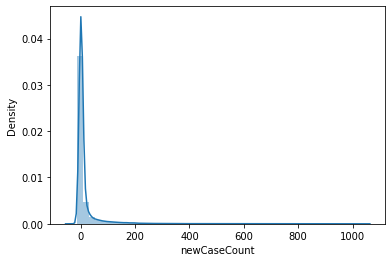

In [19]:
sns.distplot(covidDataFrame.newCaseCount)

c:\users\jfizzle\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tempSingleMean', ylabel='Density'>

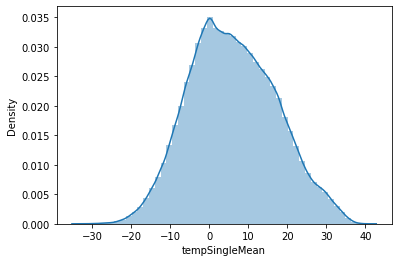

In [20]:
sns.distplot(temperatureDataFrame.tempSingleMean)

## Preprocessing

#### Flatten Frames

In [21]:
flattenedCovidDataFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/data.json'))))
flattenedCovidGeometryFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/linkedGeometry.json'))))

flattenedWindDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/data.json'))))
flattenedWindGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/linkedGeometry.json'))))

flattenedPressureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/data.json'))))
flattenedPressureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/linkedGeometry.json'))))

flattenedTemperatureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/data.json'))))
flattenedTemperatureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json'))))

flattenedPopulationDataFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/data.json'))))
flattenedPopulationGeometryFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/linkedGeometry.json'))))

#### Lookup County for Geometry

In [33]:
combinedCovidFrame = flattenedCovidDataFrame.set_index('GISJOIN').join(flattenedCovidGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')

def create_county_polygons(combinedCovidFrame):
    county_polygons = []
    df = combinedCovidFrame.groupby('county').first().reindex(columns=['coordJsonString', 'geometry.type', "geometry.coordinates"])
    print(df)
    df['coordJsonString'] = df["geometry.coordinates"].apply(json.dumps)
    for index, row in df[['coordJsonString', 'geometry.type']].iterrows():
        print(f"processing: {index}")
        shape_data = json.loads(row['coordJsonString'])
        county = index
        if row['geometry.type'] == 'MultiPolygon':
            for p in shape_data:
                s = np.asarray(p)[0]
                shape = Polygon(*s)
                county_polygons.append((county, shape))
        elif row['geometry.type'] == 'Polygon':
            s = np.asarray(shape_data)[0]
            shape = Polygon(*s)
            county_polygons.append((county, shape))
        else:
            print(f"Row had geometry type of {row['geometry.type']}, row is {row}")
    return county_polygons

if not os.path.exists(DATA_PATH + '/county_objects.pickle'):
    county_polygons = create_county_polygons(combinedCovidFrame)
    with open(DATA_PATH + '/county_objects.pickle', 'wb') as handle:
        pickle.dump(county_polygons, handle)
else:
    with open(DATA_PATH + '/county_objects.pickle', 'rb') as handle:
        county_polygons = pickle.load(handle)

def lookup_county_from_geometry(county_polygons, geometry):
    point = Point(np.asarray(geometry))
    for county, shape in county_polygons:
        if shape.encloses_point(point):
            print(f"found {county}")
            return county

In [37]:
import time
s = time.time()

flattenedPressureGeometryFrame['county'] = flattenedPressureGeometryFrame.apply(lambda row: lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)
flattenedWindGeometryFrame['county'] = flattenedWindGeometryFrame.apply(lambda row: lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)
flattenedTemperatureGeometryFrame['county'] = flattenedTemperatureGeometryFrame.apply(lambda row: lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)
print(f'took {time.time() - s}')


found Larimer
found Grand
found Boulder
found Boulder
found Weld
found Logan
found Yuma
found Larimer
found Larimer
found Larimer
found Larimer
found Boulder
found Boulder
found Boulder
found Boulder
found Weld
found Weld
found Weld
found Logan
found Logan
found Logan
found Yuma
found Larimer
found Larimer
found Larimer
found Larimer
found Grand
found Boulder
found Boulder
found Boulder
found Boulder
found Weld
found Weld
found Weld
found Logan
found Logan
found Logan
found Yuma
took 1381.855630159378


#### Join Data and Geometry

In [38]:
combinedWindFrame = flattenedWindDataFrame.set_index('site').join(flattenedWindGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPressureFrame = flattenedPressureDataFrame.set_index('site').join(flattenedPressureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedTemperatureFrame = flattenedTemperatureDataFrame.set_index('site').join(flattenedTemperatureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPopulationFrame = flattenedPopulationDataFrame.set_index('GISJOIN').join(flattenedPopulationGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')

#### Generalize Geometry

In [39]:
print(combinedWindFrame.sample(5))
print(combinedPressureFrame.sample(5))
print(combinedTemperatureFrame.sample(5))
print(combinedPopulationFrame.sample(5))


                                   startDateTime           endDateTime  \
site                                                                     
RMNP_DP1.00001.001_000.020  2018-11-10T17:00:00Z  2018-11-10T17:30:00Z   
STER_DP1.00001.001_000.010  2018-02-09T19:30:00Z  2018-02-09T20:00:00Z   
CPER_DP1.00001.001_000.030  2021-01-10T02:00:00Z  2021-01-10T02:30:00Z   
CPER_DP1.00001.001_000.010  2021-05-10T10:00:00Z  2021-05-10T10:30:00Z   
STER_DP1.00001.001_000.030  2015-02-10T06:00:00Z  2015-02-10T06:30:00Z   

                            windSpeedMean  windSpeedMinimum  windSpeedMaximum  \
site                                                                            
RMNP_DP1.00001.001_000.020           2.01              0.06              7.10   
STER_DP1.00001.001_000.010           3.27              1.39              5.52   
CPER_DP1.00001.001_000.030           1.98              1.43              2.58   
CPER_DP1.00001.001_000.010           0.89              0.19              2.7

## References

## About this Notebook

**Authors:** Kyle Bassignani, Jeff Borgerson, and Christian Westbrook  
**Updated On:** 2021-11-20